In [1]:
import pandas as pd
import tensorflow as tf

df = pd.read_csv("train.zip", header=None, names=['ClassIndex' ,'Título', 'Descrição'])

df['Texto'] = df['Título'] + ' ' + df['Descrição']

2025-08-21 16:28:38.582635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 16:28:39.347600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-21 16:28:40.651559: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df['Texto']


0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Texto, Length: 120000, dtype: object

In [3]:
import random

random.seed(42)
df_sample = df.sample(n=1_000)

In [4]:
corpus = df_sample['Texto'].tolist()

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
max_vocab_size = 20_000
max_sequence_len = 50

In [7]:
vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_sequence_length=max_sequence_len,
    output_mode='int',
)

I0000 00:00:1755804522.994614   32391 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9717 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
vectorizer.adapt(corpus)

In [9]:
tokenized_corpus = vectorizer(corpus)

In [10]:
import pickle

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [11]:
input_sequences = []

for token_list in tokenized_corpus.numpy():
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [12]:
input_sequences

[array([1128,  716]),
 array([1128,  716, 1904]),
 array([1128,  716, 1904,   67]),
 array([1128,  716, 1904,   67,  100]),
 array([1128,  716, 1904,   67,  100, 1128]),
 array([1128,  716, 1904,   67,  100, 1128, 1693]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2, 4900]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2, 4900,
           5]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2, 4900,
           5,    2]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2, 4900,
           5,    2, 1128]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2, 4900,
           5,    2, 1128, 3872]),
 array([1128,  716, 1904,   67,  100, 1128, 1693,   19, 1574,    2, 4900,
           5,    2, 1128, 3872,  286]),


In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def prepare_sequences(sequences):
    sequences_without_trailing_zeros = []
    for seq in sequences:
        last_nonzero_index = np.argmax(seq[::-1] != 0)
        if last_nonzero_index == 0 and seq[-1] == 0:
            sequences_without_trailing_zeros.append(np.array[0])
        else:
            sequences_without_trailing_zeros.append(seq[:-last_nonzero_index or None])

    unique_sequences = []
    for seq in sequences_without_trailing_zeros:
        if seq.tolist() not in unique_sequences:
            unique_sequences.append(seq.tolist())

    max_sequence_len = max(len(seq) for seq in unique_sequences)

    padded_sequences = pad_sequences(
        unique_sequences,
        maxlen=max_sequence_len,
        padding="pre",
        truncating="post",
    )

    return padded_sequences


In [15]:
input_sequence_prepared = prepare_sequences(input_sequences)

In [16]:
print(input_sequence_prepared)

[[   0    0    0 ...    0 1128  716]
 [   0    0    0 ... 1128  716 1904]
 [   0    0    0 ...  716 1904   67]
 ...
 [   0    0    0 ...   64   18 5228]
 [   0    0    0 ...   18 5228    7]
 [   0    0    0 ... 5228    7  933]]


In [17]:
X = input_sequence_prepared[:,:-1]
y = input_sequence_prepared[:,-1]

In [18]:
y

array([ 716, 1904,   67, ..., 5228,    7,  933],
      shape=(36093,), dtype=int32)

In [19]:
y = tf.keras.utils.to_categorical(y, num_classes=max_vocab_size)

In [20]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(36093, 20000))

In [21]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_vocab_size,
        output_dim=128,
        mask_zero=False,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(max_vocab_size, activation='softmax'),
])

In [22]:
modelo.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

In [23]:
history = modelo.fit(X, y, epochs=100, verbose=1, batch_size=64)

Epoch 1/100


2025-08-21 16:28:54.436470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91100


564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.0440 - loss: 8.3964
Epoch 2/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.0597 - loss: 7.4283
Epoch 3/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0756 - loss: 7.1561
Epoch 4/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.0889 - loss: 6.8879
Epoch 5/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.0994 - loss: 6.6290
Epoch 6/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.1125 - loss: 6.3581
Epoch 7/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1292 - loss: 6.0757
Epoch 8/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1420 - loss: 5.8095
Epoch 9/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1569 - loss: 5.5454
Epoch 10/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1721 - loss: 5.2951
Epoch 11/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1901 - loss: 5.0697
Epoch 12/100
564/564 ━━━━━━━━━━

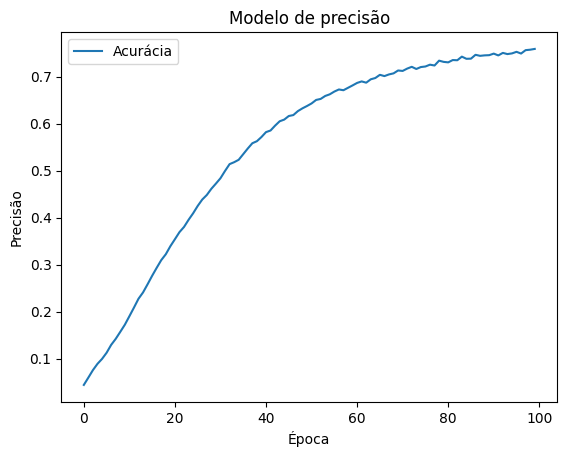

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Modelo de precisão')
plt.ylabel('Precisão')
plt.xlabel('Época')
plt.legend(['Acurácia'], loc='upper left')
plt.show()

In [36]:
def predict_next_words(model, vectorizer, text, max_sequence_len, top_k=3):
    tokenized_text = vectorizer([text])
    tokenized_text = np.squeeze(tokenized_text)

    padded_text = pad_sequences([tokenized_text], maxlen=max_sequence_len, padding='pre')

    predicted_probs = model.predict(padded_text, verbose=0)[0]

    top_k_indices = np.argsort(predicted_probs)[-top_k:][::-1]

    predicted_words = [vectorizer.get_vocabulary()[index] for index in top_k_indices]

    return predicted_words


In [37]:
text = "The FBI is warning consumers against using public phone charging stations in order to"

In [39]:
predict_next_words(modelo, vectorizer, text, 50, top_k=6)

[np.str_('proves'),
 np.str_('striving'),
 np.str_('khin'),
 np.str_('analysts'),
 np.str_('crash'),
 np.str_('wakeup')]

In [26]:
history

In [42]:
text = "Apple needs to make the iPhone"
predict_next_words(modelo, vectorizer, text, 50, top_k=3)

[np.str_('4717'), np.str_('tiger'), np.str_('striving')]

In [43]:
modelo.save('modelo_vidente.keras')